## A PyTorch Primer

In this tutorial, we are going to dive into another commonly used deep learning library, PyTorch. Compared to TensorFlow, the syntax of PyTorch is easier, and usually PyTorch is more suitable for rapid development and experiment with new ideas. Here let's look at an example where we'll build a convolutional neural network, load the CIFAR10 dataset and train the network on the dataset.

In [1]:
import torch
import torch.nn as nn             # The object-oriented API
import torch.nn.functional as F   # The functional API

print(torch.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1.1.0


### 1. Build a CNN model

The first thing we're going to do is to build a neural network model using use the object-oriented API. To do this, we need to define a class for our model that inherits the <code>nn.Module</code> base class. There are two major things we need to define. The first is the <code>\_\_init\_\_</code> method where we need to define all layers of the neural network, and the second is the <code>forward</code> method which determines how input will be transformed to produce the output.

The architecture of our network is as follows:
<img src="files/LeNet-5.png">

#### TODO: Convolution filter

In [2]:
class ConvNet(nn.Module): # Subclasses nn.Module
    
    # The constructor of the class should contain all layers with trainable parameters of the neural network.
    def __init__(self):
        
        # Call the constructor of the base class.
        super(ConvNet, self).__init__()
        
        # torch.nn contains pre-defined layers that are also subclasses of the nn.Module base class.
        # The first two arguments of nn.Conv2d indicate `in_channels` and `out_channels`.
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        
        # The pooling layer has no trainable parameters. It is also possible to use the functional interface.
        # However, using the object-oriented interface allows us to add its hyperparameters to the argument of
        # the constructor.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        
        # The dense layers.
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    # The `forward` method determines how input is tranformed into the output.
    def forward(self, x): # `x` is the input tensor
        
        # Passing a tensor to a nn.Module instance invokes its `forward` method.
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 16 * 5 * 5)            # Flatten, converts from a 4D tensor of shape [batch_size, height, width, channel] 
                                              # to a 2D tensor of shape [batch_size, channel * height * width].
        x = F.relu(self.fc1(x))               # Dense1
        x = F.relu(self.fc2(x))               # Dense2
        x = self.fc3(x)                       # Dense3
        return x                              # Returns the `logits`

In [3]:
net = ConvNet()  # Create a ConvNet instance.

### 2. Load CIFAR-10 data

CIFAR-10 is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

Loading CIFAR-10 is very easy using the <code>torchvision</code> package, which is a part of PyTorch and contains popular datasets, model architectures and common image transformations for computer vision.

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
# The dataset contains PIL (Python image library) images. We need to do some transformations when loading.

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to tensor.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # For each channel, transform values from [0, 1] to [-1, 1]. Not necessary.
])

# Load the training set and apply the above transformations.
# `trainset` and `testset` are `torch.utils.data.Dataset` instances.
# For other datasets, generate `torch.utils.data.Dataset` instances to store your data.
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use subsets of the datasets since the original datasets are too large.
# torch.utils.data.Dataset
# torch.utils.data.DataLoader
train_ind = np.random.choice(np.arange(50000, dtype=int), 10000, replace=False)
test_ind = np.random.choice(np.arange(10000, dtype=int), 1000, replace=False)
trainset = torch.utils.data.Subset(trainset, train_ind)
testset = torch.utils.data.Subset(testset, test_ind)

Files already downloaded and verified
Files already downloaded and verified


When loading a dataset, our final goal would be to generate a instance of the <code>torch.utils.data.DataLoader</code> class, which can handle a lot of data loading utilities. It is basically an iterable over a dataset, and supports functionalities such as automatic batching and multi-process data loading.

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2) # Shuffle the training set and set a batch size of 4.
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)  # No need to shuffle the test set.

In [11]:
# Let's define all the class labels.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

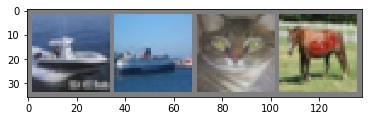

 ship  ship   cat horse


In [12]:
# Here is what the images look like.

def my_imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # `plt.imshow()` is a function to plot images.
    plt.show()

# Get one batch of random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Show images
my_imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 3. Define a loss function and choose an optimizer

Most commonly used loss functions can be found in the <code>torch.nn</code> submodule, and most optimizers can be found in the <code>torch.optim</code> submodule. 

In [13]:
import torch.optim as optim

# For the multi-label classification task, we usually use the cross-entropy loss function.
# For binary classification, we use the BCELoss. (Binary cross-entropy loss)
# For regression, we usually use MSELoss. (Mean squared error loss)

# Notice that the input is expected to contain raw, unnormalized scores for each class, e.g. the logits.
# This is why we didn't add a softmax layer after the last fully-connected layer.

criterion = nn.CrossEntropyLoss()


# Let's use the Adam optimizer with a learning rate of 0.001.
# 0.001 is a typical learning rate, and when tuning learning rates at the beginning, one usually tries in various orders of 10, 
# from high to low, e.g. 1, 0.1, 0.01, 0.001, ...
# Weight decay ...

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.0001)

### 4. Train the neural network

To train the neural network, we just need to iterate through our dataset and feed the input to the neural network model.

In [14]:
device = torch.device('cuda:1') # GPU 1, the second GPU on this server.
net = net.to(device) # Move the model to the GPU

loss_per_epoch = []
for epoch in range(20): # Train for 20 epochs.
    running_loss = []
    for i, data in enumerate(trainloader):
        inputs, labels = data # Get the inputs; data is a list of [inputs, labels]
        # Move inputs and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # By default, the optimizer will not clear up the gradient.
        # from the previous backpropagation step.
        # If we do not clear up the gradient, gradients will be automatically added up.
        # Therefore, we need to manually zero out the gradient before each step.
        
        # More precisely, each trainable parameter in PyTorch maintains a `grad` variable, which will not automatically
        # be cleared after each backpropagation step. This is when `zero_grad()` comes into play. In optimizers where
        # quantities about previous gradients need to be documented, they will be stored in the `state` variable of the
        # parameter.
        optimizer.zero_grad()
        
        # One iteration: forward + backward
        outputs = net(inputs)             # Feed the input to the network.
        loss = criterion(outputs, labels) # Calculate loss.
        loss.backward()                   # Compute gradient for every trainable parameter.
        optimizer.step()                  # Perform a parameter update based on the current gradient and the update rule.
        
        # Accumulate loss
        running_loss += [loss.item()]
    loss_per_epoch.append(np.mean(running_loss))
    print('Epoch %d: loss = %.3f' % (epoch + 1, np.mean(running_loss)))

Epoch 1: loss = 1.833
Epoch 2: loss = 1.555
Epoch 3: loss = 1.433
Epoch 4: loss = 1.342
Epoch 5: loss = 1.259
Epoch 6: loss = 1.177
Epoch 7: loss = 1.098
Epoch 8: loss = 1.024
Epoch 9: loss = 0.947
Epoch 10: loss = 0.864
Epoch 11: loss = 0.796
Epoch 12: loss = 0.723
Epoch 13: loss = 0.655
Epoch 14: loss = 0.614
Epoch 15: loss = 0.559
Epoch 16: loss = 0.508
Epoch 17: loss = 0.469
Epoch 18: loss = 0.428
Epoch 19: loss = 0.409
Epoch 20: loss = 0.374


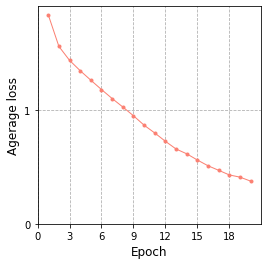

In [17]:
fig, ax = plt.subplots()
fig.set_figwidth(4)
fig.set_figheight(4)

ax.plot(np.arange(20) + 1, loss_per_epoch, lw=1, color='#fb8072', marker='o', markersize=3)
ax.set_xticks(np.arange(0, 20, 3))
ax.set_yticks(np.arange(0, 2, 1))
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Agerage loss', fontsize=12)
ax.grid(True, ls='--')

### 5. Test the neural network

To test the neural network, we just need to fix all parameters of the neural network and calculate the predicted label.

In [18]:
correct = 0
total = 0

with torch.no_grad(): # This basically sets the `requires_grad` flag of all parameters to false, i.e. no parameter is trainable.
    for data in testloader: # Iterates through test data.
        inputs, labels = data
        # Move inputs and labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = net(inputs) # `outputs` is a 2D tensor of [batch_size, 10].
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1) # `predicted` is a 1D tensor of size [batch_size].
        
        # How many data points are there and how many are predicted correctly.
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 1000 test images: 48 %
